In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob
from pycorn import pc_uni6
from scipy.stats import gaussian_kde

cmap_tab = plt.get_cmap('tab10')
cmap_seq = plt.get_cmap('viridis')
cmap_blue = plt.get_cmap('Blues')

# yeast display data

In [4]:
base_dir = '../figure3_A02-characterization-yeast/20250806_Tina_A02_yeast_display/single_cells/'
data = pd.read_csv(f'{base_dir}export_A02 TAX_hit6_2_Single Cells.csv')
data

,FSC-A,FSC-H,SSC-A,SSC-H,FITC_HA-A,FITC_HA-H,PE-A,PE-H,PerCP-A,PerCP-H,APC_A6c134tet-A,APC_A6c134tet-H,Time
0,1762140.0,1812550.0,83106,106212,24964,22952,2727,3061,934,1304,10052,9867,13.7
1,1923000.0,1983360.0,87026,119608,15767,14843,1974,1661,1054,1046,7493,3510,13.7
2,3066060.0,2914800.0,278484,373312,3488,3396,703,819,155,861,0,613,13.7
3,1972460.0,1785680.0,128320,151766,577,407,176,326,516,914,1435,2431,13.7
4,1777580.0,1806940.0,113372,152681,42095,39415,5455,5239,2181,2644,16143,11515,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,1128920.0,1271350.0,75424,107144,14051,13637,1667,1565,837,666,6259,4414,15.1
8159,1991470.0,1918140.0,155230,213246,47613,43451,5551,4772,2728,1684,11051,10738,15.1
8160,944482.0,1117460.0,58205,80592,9990,10433,1319,1513,778,872,5428,4653,15.1
8161,1186240.0,1359800.0,64112,87510,5704,6122,650,598,4,314,297,2102,15.1


[]

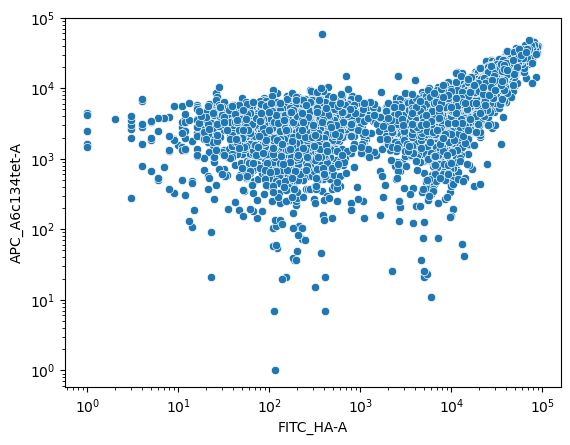

In [6]:
sns.scatterplot(data=data,x='FITC_HA-A',y='APC_A6c134tet-A')
plt.loglog()

In [8]:
def read_code(code):
    files = glob(f'{base_dir}export_{code}*_Single Cells.csv')
    assert len(files) == 1
    data = pd.read_csv(files[0])
    return data

2.992992992992993


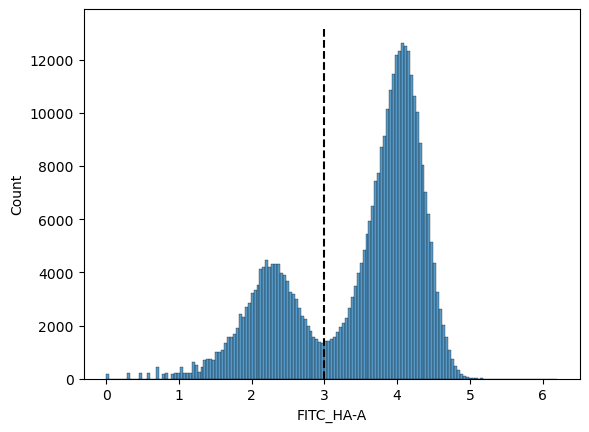

In [10]:
rows = {
    'A':'TCR (A6c134)',
    'B':'TCR (ctrl)',
    'C':'anti-A02',
    'D':'SA (ctrl)'
}

cols = {
    'hit6':[1,2,3],
    'CSM8':[7,8,9],
    'CSM8-L11':[4,5,6],
    'SCT':[10,11,12]
}

#get cutoff
expr = pd.concat([read_code(f'{row}{str(col).zfill(2)}')[['FITC_HA-A']] for row in rows for name in cols for col in cols[name]],axis=0)
expr = expr[expr['FITC_HA-A']>0]
kde = gaussian_kde(np.log10(expr.values.flatten()))
x_kde = np.linspace(2,4,1000)
y_kde = kde.pdf(x_kde)
cutoff = x_kde[y_kde==min(y_kde)][0]
print(cutoff)

sns.histplot(np.log10(expr['FITC_HA-A']))
plt.plot([cutoff]*2,plt.ylim(),'k--')

In [12]:
stain_name = {
    'A':'APC_A6c134tet-A',
    'B':'APC_S6Htet-A',
    'C':'APC_A2-A',
    'D':'APC_SA-A'
}
stain_cutoff = {}
for row in ['A','C']:
    tag_neg = []
    for name in cols:
        for col in cols[name]:
            code = f'{row}{str(col).zfill(2)}'
            data = read_code(code)
            tag_neg.append(data[np.log10(data['FITC_HA-A'])<=cutoff])
    tag_neg = pd.concat(tag_neg,axis=0)
    stain_cutoff[rows[row]] = np.quantile(tag_neg[stain_name[row]],0.99)
print(stain_cutoff)

{'TCR (A6c134)': 6969.800000000003, 'anti-A02': 3577.480000000003}


/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-pack

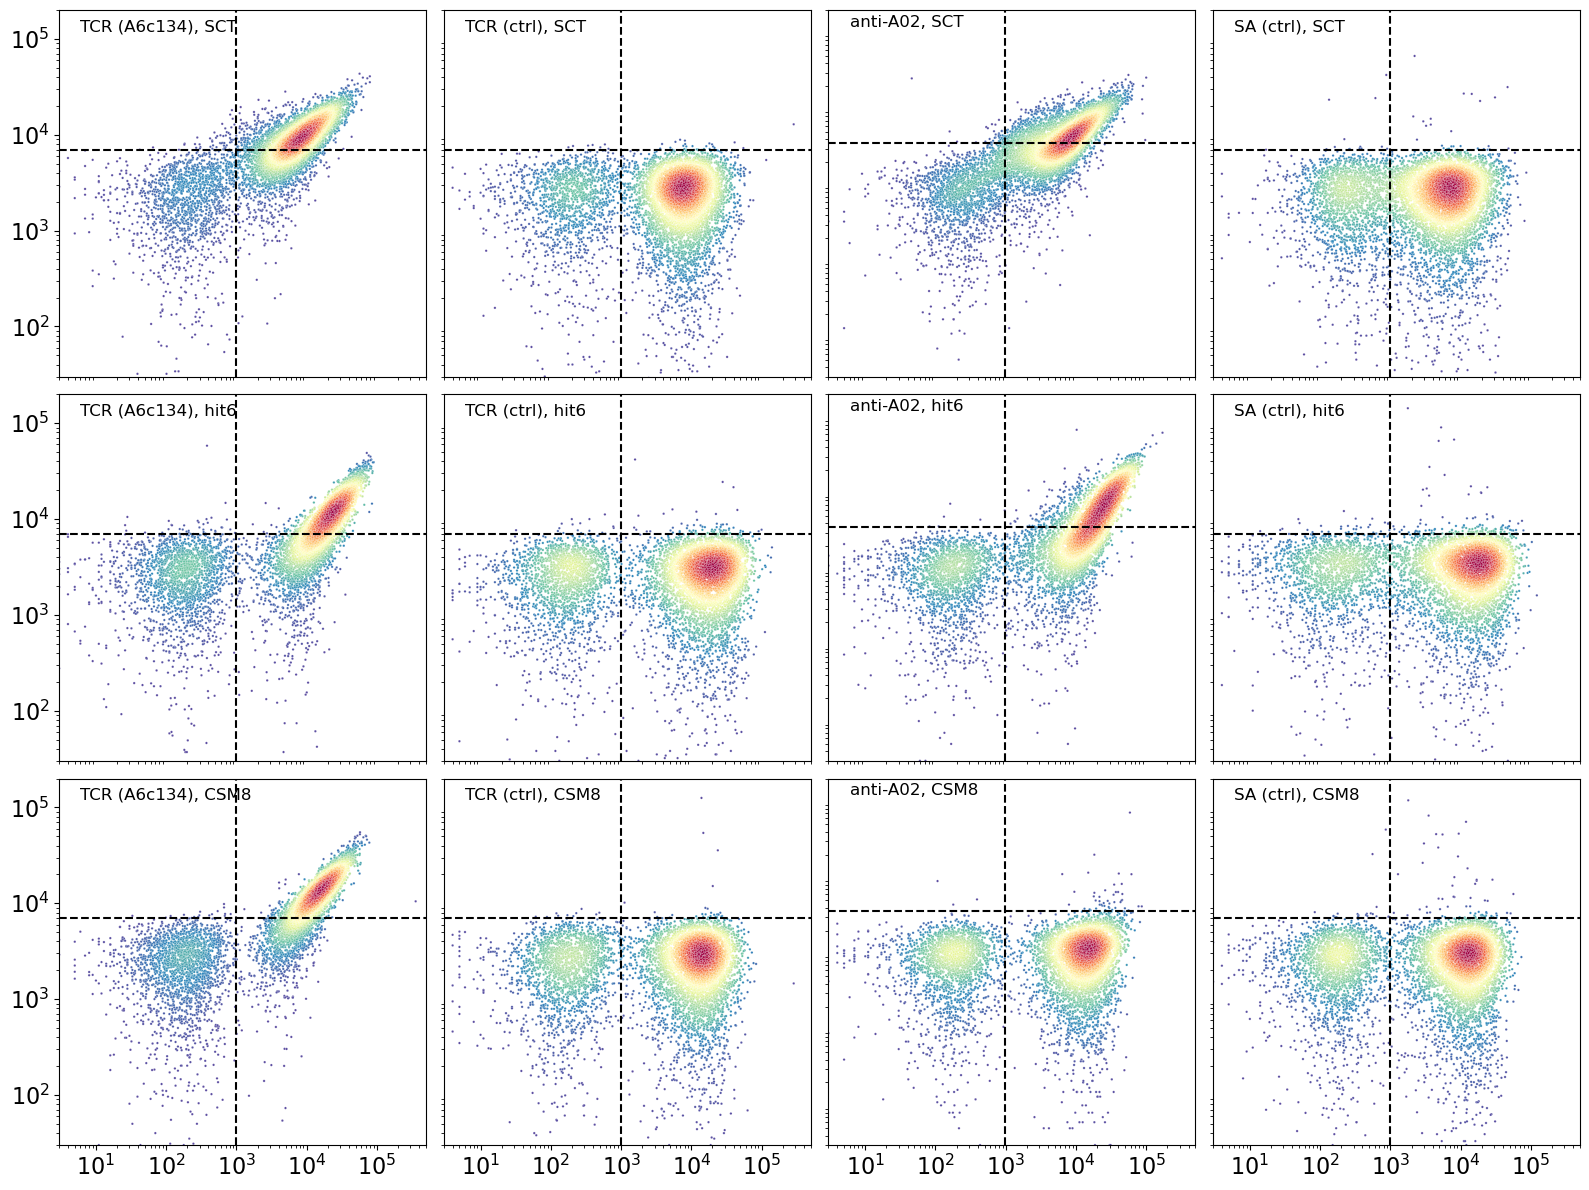

In [56]:
plt.figure(figsize=[16,12])
lims = {
    'TCR (A6c134)':[30,2e5],
    'anti-A02':[3,2e5]
}

cutoff_name = {
    'A':'TCR (A6c134)',
    'B':'TCR (A6c134)',
    'C':'anti-A02',
    'D':'TCR (A6c134)'
}
for r,row in enumerate(rows):
    for c,name in enumerate(['SCT','hit6','CSM8']):
        code = f'{row}{str(cols[name][1]).zfill(2)}'
        data = read_code(code)

        usable = data.loc[(data['FITC_HA-A']>0)&(data[stain_name[row]]>0),['FITC_HA-A',stain_name[row]]]
        kde = gaussian_kde(np.log10(usable.values.T))

        plt.subplot(3,4,r + 4*c + 1)
        sns.scatterplot(data=usable,
                        x='FITC_HA-A',
                        y=stain_name[row],
                        hue=kde.pdf(np.log10(usable.values.T)),
                        legend=None,
                        palette='Spectral_r',
                        s=3)

        plt.plot([3,5e5],[stain_cutoff[cutoff_name[row]]]*2,'k--')
        plt.plot([10**cutoff]*2,lims[cutoff_name[row]],'k--')

        plt.xlim([3,5e5])
        plt.ylim(lims[cutoff_name[row]])
        plt.loglog()

        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        plt.text(6, 1.2e5, f'{rows[row]}, {name}',fontsize=12)

        if c!=2:
            plt.xticks([])
        if r!=0:
            plt.yticks([])
        
plt.tight_layout()
# plt.savefig('example_flow_plots.png',dpi=300,bbox_inches='tight')